In [ ]:
!pip install keyboard

In [59]:
import time
import numpy as np
from gym import Env
from gym.spaces import Box, Discrete
import random
import random
from IPython.display import clear_output
from time import sleep
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import keyboard
import matplotlib.pyplot as plt

https://keras.io/guides/writing_a_training_loop_from_scratch/#lowlevel-handling-of-losses-tracked-by-the-model

In [60]:
def actionAsk():
    if keyboard.is_pressed('Down'):
        return 0
    if keyboard.is_pressed('Left'):
        return 1
    if keyboard.is_pressed('Up'):
        return 2
    if keyboard.is_pressed('Down'):
        return 3
    return -1


In [61]:
class Point2():
    def __init__(self, x=0, y=0):
        self._info = np.array([x, y], ndmin=1)

    @property
    def x(self):
        return self._info[0]

    @property
    def y(self):
        return self._info[1]

    @x.setter
    def x(self, a):
        self._info[0] = a

    @y.setter
    def y(self, a):
        self._info[1] = a

    def __add__(self, o):
        return Point2(self._info[0] + o._info[0], self._info[1] + o._info[1])

    def __sub__(self, o):
        return Point2(self._info[0] - o._info[0], self._info[1] - o._info[1])

    def __eq__(self, other):
        if np.all(np.equal(self._info, other._info)):
            return True
        else:
            return False

In [105]:
class CustomEnv(Env):
    def __init__(self, h=10, w=10):
        self.WIDTH = w
        self.HEIGHT = h
        self.action_space = Discrete(4)
        self.observation_space = Box(low=-self.HEIGHT, high=self.HEIGHT, shape=(2, 2), dtype=int)
        self.snake = [Point2(0, 0)]
        self.food = Point2(0, 0)
        self.aim = Point2(0, -1)
        self.endGame = False
        self.memory = 0

    def inside(self, head):
        return -1 < head.x < self.WIDTH and -1 < head.y < self.HEIGHT

    def change(self, action):
        if action == 0:
            self.aim.x = 0
            self.aim.y = -1
        elif action == 1:
            self.aim.x = -1
            self.aim.y = 0
        elif action == 2:
            self.aim.x = 0
            self.aim.y = 1
        elif action == 3:
            self.aim.x = 1
            self.aim.y = 0
        else:
            pass

    def step(self, action):
        self.change(action)
        head = self.snake[-1] + self.aim
        if (not self.inside(head) or head in self.snake) and self.aim != Point2(0, 0):
            self.endGame = True
            reward = 0.4
            done = True
        else:
            done = False
            self.snake.append(head)

            if head == self.food:
                while self.food in self.snake:
                    self.food = self.rPoint()
                reward = 0.000001
            else:
                prev = np.array([np.abs(self.snake[-2].x - self.food.x), np.abs(self.snake[-2].y - self.food.y)])
                cur = np.array([np.abs(self.snake[-1].x - self.food.x), np.abs(self.snake[-1].y - self.food.y)])

                if prev[0] < cur[0] or prev[1] < cur[1]:
                    reward = 0.29
                elif np.abs(self.memory-action) == 2:
                    reward = 0.3
                else:
                    reward = 0.09
                self.snake.pop(0)

        # Setting the placeholder for info
        info = len(self.snake)
        self.memory = action
        # Returning the step information
        return self.snakePos(), reward, done, info

    def render(self, episode, reward):
        clear_output(wait=True)
        s = ''
        for i in range(-1, self.WIDTH + 1):
            for j in range(-1, self.HEIGHT + 1):
                if Point2(i, j) == self.snake[-1]:
                    s = s + '0'
                elif Point2(i, j) in self.snake:
                    s = s + '█'
                elif Point2(i, j) == self.food:
                    s = s + 'X'
                elif j == -1 or j == self.HEIGHT:
                    s = s + '‖'
                elif i == -1 or i == self.WIDTH:
                    s = s + '='
                else:
                    s = s + '·'
            s = s + '\n'
        s = s + 'Episode:{} Score:{} Snake:{}'.format(episode, reward, len(self.snake))
        print(s)

    def position(self, pos) -> int:
        return pos.x * self.WIDTH + pos.y

    def snakePos(self):
        obsspc = np.zeros(self.HEIGHT * self.WIDTH, dtype=np.float64)
        for i in range(len(self.snake)):
            obsspc[self.position(self.snake[i])] = 0.33
        obsspc[self.position(self.snake[-1])] = 0.66
        obsspc[self.position(self.food)] = 0.99
        return obsspc

    def rPoint(self) -> Point2:
        x = random.randint(0, self.WIDTH - 1)
        y = random.randint(0, self.HEIGHT - 1)
        return Point2(x, y)

    def reset(self, seed=2, playerSeed=False):
        if (playerSeed):
            random.seed(seed)
        else:
            t = 1000 * time.time()  # current time in milliseconds
            random.seed(int(t) % 2 ** 32)
        self.snake = [self.rPoint()]
        self.food = self.rPoint()
        self.aim = Point2(0, 0)
        self.endGame = False
        return self.snakePos()

In [116]:
h = w = 10
env = CustomEnv(h, w)
#rule
#likirelu
#sigmoid
#th
inputs = keras.Input(shape=(h * w,), name="digits")
x1 = layers.Dense(128, activation="relu")(inputs)
x2 = layers.Dense(64, activation="relu")(x1)
x3 = layers.Dense(64, activation="relu")(x2)
outputs = layers.Dense(4, name="predictions")(x3)
model = keras.Model(inputs=inputs, outputs=outputs)

In [117]:
# Instantiate an optimizer.
optimizer = keras.optimizers.SGD(learning_rate=1e-3)
# Instantiate a loss function.
loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)


In [118]:
epochs = 500
allReward = []
allScores = []
allSteps = []
allDicts = []
for epoch in range(epochs):
    print("\nStart of epoch %d" % (epoch,))
    done = False
    reward = 0
    agent = env.reset()
    score = 0
    sumReward = 0
    step = 0
    info = 1
    dict = {1:0,
        2:0,
        3:0,
        0:0}
    # Iterate over the batches of the dataset.
    #for i in range(100):
    while not done and step < 100:
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tf.GradientTape() as tape:

            batch_size = 1

            # Prepare the validation dataset.
            input = tf.convert_to_tensor(np.array([agent]), dtype=tf.float32)

            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(input, training=True)  # Logits for this minibatch
            agent, reward, done, score = env.step(np.argmax(logits[0]))
            sumReward = sumReward + reward
            #env.render(epoch,allreward)
            step = step + 1
            # Compute the loss value for this minibatch.
            #loss_value = loss_fn(y_batch_train, logits)
            temp = tf.reduce_sum(tf.multiply(logits, tf.convert_to_tensor(0.))),
            loss_value = tf.add(temp, tf.convert_to_tensor(121, dtype=tf.float32))

        # Use the gradient tape to automatically retrieve
        # the gradients of the trainable variables with respect to the loss.
        grads = tape.gradient(loss_value, model.trainable_weights)

        # Run one step of gradient descent by updating
        # the value of the variables to minimize the loss.
        optimizer.apply_gradients(zip(grads, model.trainable_weights))
        dict[np.argmax(logits[0])] = dict[np.argmax(logits[0])] +1
        # Log every 200 batches.
        print(
            '\r'+"Epi %d Training loss (for one batch) at step %d: %.4f"
            % (epoch,step, float(sumReward))

        )
        print('\rdown  is'+str(dict[0]))
        print('\rleft  is'+str(dict[1]))
        print('\rup    is'+str(dict[2]))
        print('\rright is'+str(dict[3]))
        clear_output(wait=True)

    allReward.append(sumReward)
    allScores.append(len(env.snake))
    allSteps.append(step)
    allDicts.append(dict)

Epi 499 Training loss (for one batch) at step 100: 29.2900
down  is50
left  is0
up    is50
right is0


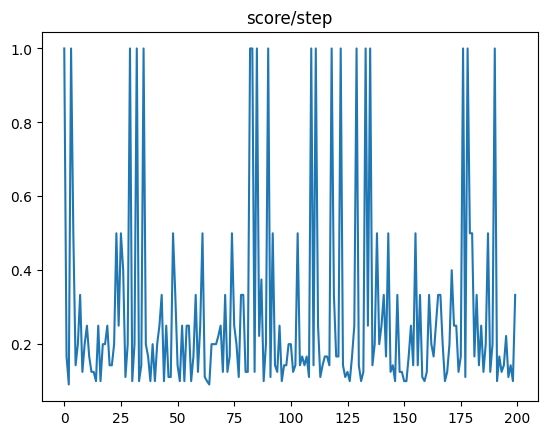

In [109]:
scorestep = []
rewardstep = []
down = []
left = []
up =[]
right = []
for i in range(epochs):
    scorestep.append(float(allScores[i])/float(allSteps[i]))
    rewardstep.append(float(allReward[i])/float(allSteps[i]))
    down.append( allDicts[i][0] / (allDicts[i][0] + allDicts[i][1] + allDicts[i][2] + allDicts[i][3]))
    left.append( allDicts[i][1] / (allDicts[i][0] + allDicts[i][1] + allDicts[i][2] + allDicts[i][3]))
    up.append(   allDicts[i][2] / (allDicts[i][0] + allDicts[i][1] + allDicts[i][2] + allDicts[i][3]))
    right.append(allDicts[i][3] / (allDicts[i][0] + allDicts[i][1] + allDicts[i][2] + allDicts[i][3]))
plt.title('score/step')
plt.plot(scorestep)

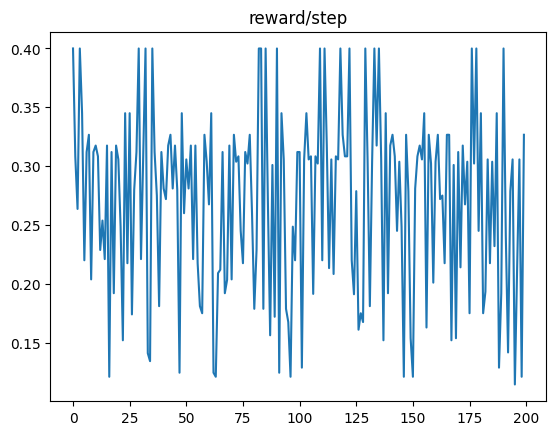

In [110]:
plt.title('reward/step')
plt.plot(rewardstep)

Text(0.5, 1.0, 'reward and steps')

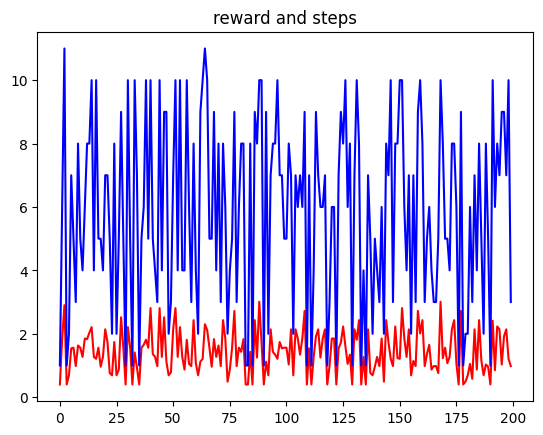

In [111]:
plt.plot(allReward,color='red')
plt.plot(allSteps,color='blue')
plt.title('reward and steps')

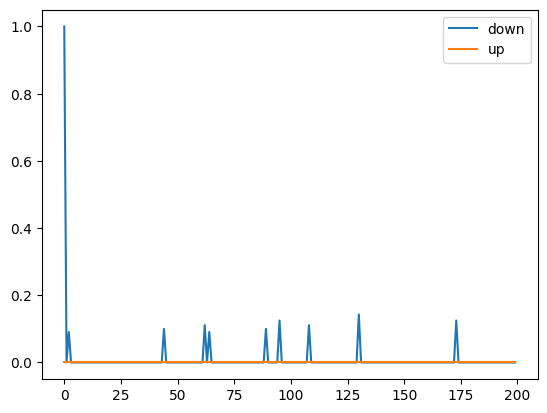

In [112]:
downl, = plt.plot(down,label = 'down')
upl, = plt.plot(up, label = 'up')
plt.legend(handles=[downl,upl])


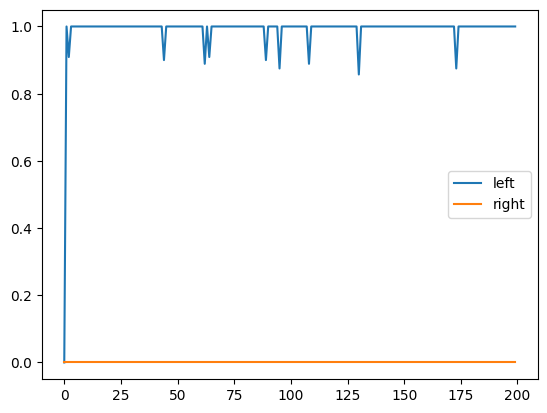

In [113]:
leftl, = plt.plot(left,label ='left')
rightl, = plt.plot(right, label = 'right')
plt.legend(handles=[leftl,rightl])

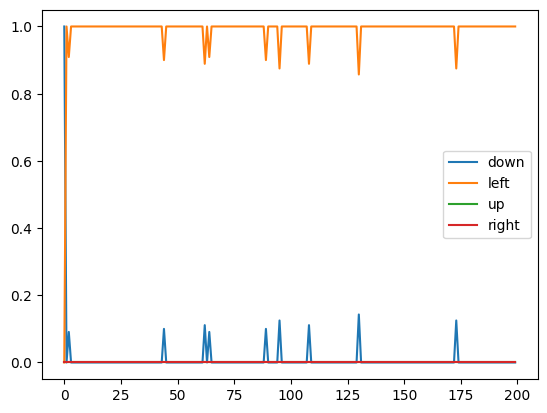

In [114]:
downl, = plt.plot(down,label = 'down')
leftl, = plt.plot(left,label ='left')
upl, = plt.plot(up, label = 'up')
rightl, = plt.plot(right, label = 'right')
plt.legend(handles=[downl,leftl,upl,rightl])

In [115]:
episodes = 500
rrr = []
for epi in range(episodes):
    print("\nStart of epoch %d" % (episodes,))
    done = False
    reward = 0
    agent = env.reset()
    score = 0
    allreward = 0
    step = 0
    info = 1
    env.render(epi,score)
    # Iterate over the batches of the dataset.
    while not done and step < 100:
        input = tf.convert_to_tensor(np.array([agent]), dtype=tf.float32)  # Logits for this minibatch
        action = model.predict(input)
        agent, reward, done, score = env.step(np.argmax(action))
        env.render(epi,score)
        allreward = allreward + reward
        step = step + 1
        sleep(0.05)
        # Log every 200 batches.
        print(
            '\r'+"Epi %d Training loss (for one batch) at step %d: %.4f"
            % (epi,step, float(allreward))
        )
    rrr.append(allreward)
    print("Seen so far: %s samples" % epoch)
    print("Score is: %s" % info)

‖==========‖
‖··········‖
‖··········‖
‖0·········‖
‖··········‖
‖··········‖
‖··········‖
‖··········‖
‖··X·······‖
‖··········‖
‖··········‖
‖==========‖
Episode:12 Score:1 Snake:1
Epi 12 Training loss (for one batch) at step 2: 0.5800


KeyboardInterrupt: 

In [77]:
agent = env.reset()

input = tf.convert_to_tensor(np.array([agent]), dtype=tf.float32)  # Logits for this minibatch
action = model.predict(input)
np.argmax(action)

1/1 [==============================] - 0s 17ms/step


1